In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

In [2]:
(xtrain,ytrain),(xtest,ytest)= tf.keras.datasets.mnist.load_data()

In [3]:
xtrain.shape

(60000, 28, 28)

In [4]:
xtest.shape

(10000, 28, 28)

In [5]:
ytest.shape

(10000,)

In [6]:
ytrain.shape

(60000,)

In [7]:
ytrain[0]

5

In [8]:
# Check whether GPU is being or not
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2734890966352796269
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 12238322266
locality {
  bus_id: 1
}
incarnation: 14369995547518398412
physical_device_desc: "device: 0, name: DML, pci bus id: <undefined>"
xla_global_id: -1
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 7577659264
locality {
  bus_id: 1
}
incarnation: 12153298646545044227
physical_device_desc: "device: 1, name: DML, pci bus id: <undefined>"
xla_global_id: -1
]


In [9]:
ytest

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [10]:
from keras.models import Sequential
import time
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
import seaborn as sns
from tensorflow.keras.layers import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from sklearn.preprocessing import LabelBinarizer
from keras.optimizers import *
from keras.layers import Layer
from keras import backend as K
from keras.regularizers import l2
K.set_image_data_format('channels_last')
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
import numpy.random as rng
from sklearn.utils import shuffle

%matplotlib inline
%load_ext autoreload
%reload_ext autoreload

Text(0.5, 1.0, 'Plot of weights initialized, with mean of 0.0 and standard deviation of 0.01')

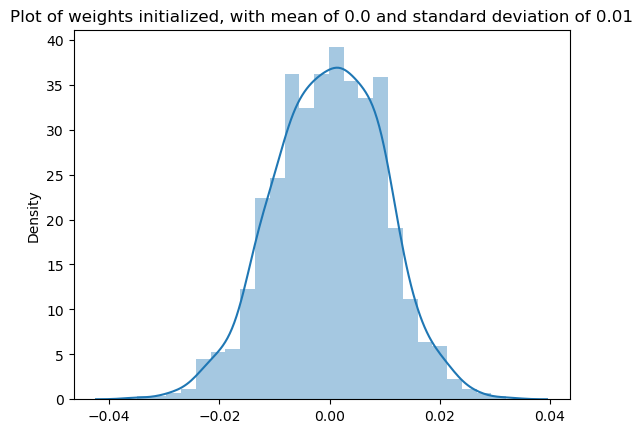

In [11]:
def initialize_weights(shape, name=None,dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)


# Intialize bias with mean 0.0 and standard deviation of 10^-2
weights = initialize_weights((1000,1))
sns.distplot(weights)
plt.title("Plot of weights initialized, with mean of 0.0 and standard deviation of 0.01")

Text(0.5, 1.0, 'Plot of biases initialized, with mean of 0.0 and standard deviation of 0.01')

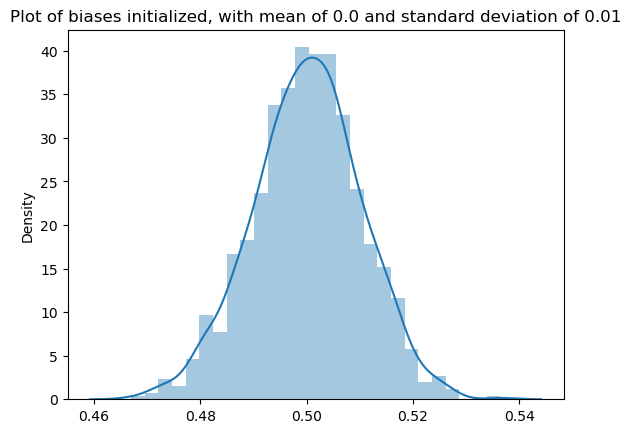

In [12]:
def initialize_bias(shape, name=None,dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)


# Intialize bias with mean 0.5 and standard deviation of 10^-2
bias = initialize_bias((1000,1))
sns.distplot(bias)
plt.title("Plot of biases initialized, with mean of 0.0 and standard deviation of 0.01")

In [13]:
def get_siamese_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    return siamese_net

In [14]:
import cv2
import numpy as np

# Assuming 'image' is your NumPy array representing the image
# and 'scale_factor' is the factor by which you want to upscale the image.
scale_factor=4
# Upscale using cv2.resize
upscaled_images = np.empty((60000,112,112))

for i, image in enumerate(xtrain):
    upscaled_images[i] = cv2.resize(image, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)

In [15]:
xtrain.shape

(60000, 28, 28)

In [16]:
upscaled_images.shape

(60000, 112, 112)

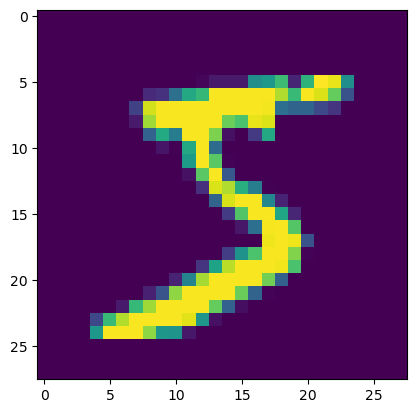

In [17]:
plt.imshow(xtrain[0])

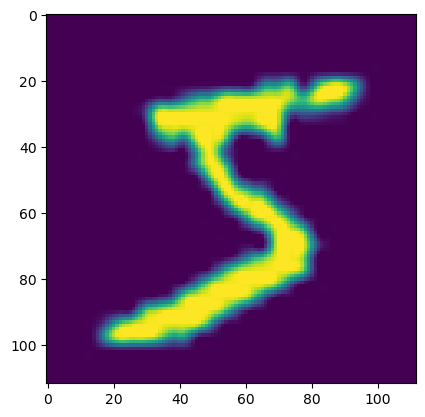

In [18]:
plt.imshow(upscaled_images[0])

In [19]:
model = get_siamese_model((112,112, 1))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 112, 112, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 112, 112, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 4096)         38947648    ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [20]:
optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer)

In [21]:
upscaled_images.shape

(60000, 112, 112)

In [22]:
def make_batch(batch_size):
    X = upscaled_images
    Y = ytrain
    n_examples,w,h = X.shape
    n_classes = np.unique(ytrain)
    categories = rng.choice(n_classes,size=(batch_size,),replace=True)
    pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
    targets=np.zeros((batch_size,))
    targets[batch_size//2:] = 1
    for i in range(batch_size):
            category = categories[i]
            idx_1 = rng.randint(0, n_examples)
            pairs[0][i,:,:,:] = X[idx_1].reshape(w, h, 1)
            idx_2 = rng.randint(0, n_examples)
            #pick images of same class for 1st half, different for 2nd
            if ytrain[idx_1] == ytrain[idx_2]:
                targets[i] = 1  
            else: 
                #add a random number to the category modulo n classes to ensure 2nd image has
                # ..different category
                category_2 = (category + rng.randint(0,9)) % n_classes
                targets[i] = 0
            pairs[1][i,:,:,:] = X[idx_2].reshape(w, h,1)
    return pairs, targets
    
p,t = make_batch(8)

In [23]:
p[0].shape

(8, 112, 112, 1)

In [24]:
p[1].shape

(8, 112, 112, 1)

In [25]:
t

array([1., 0., 0., 0., 0., 0., 0., 0.])

[1. 0. 0. 0.]


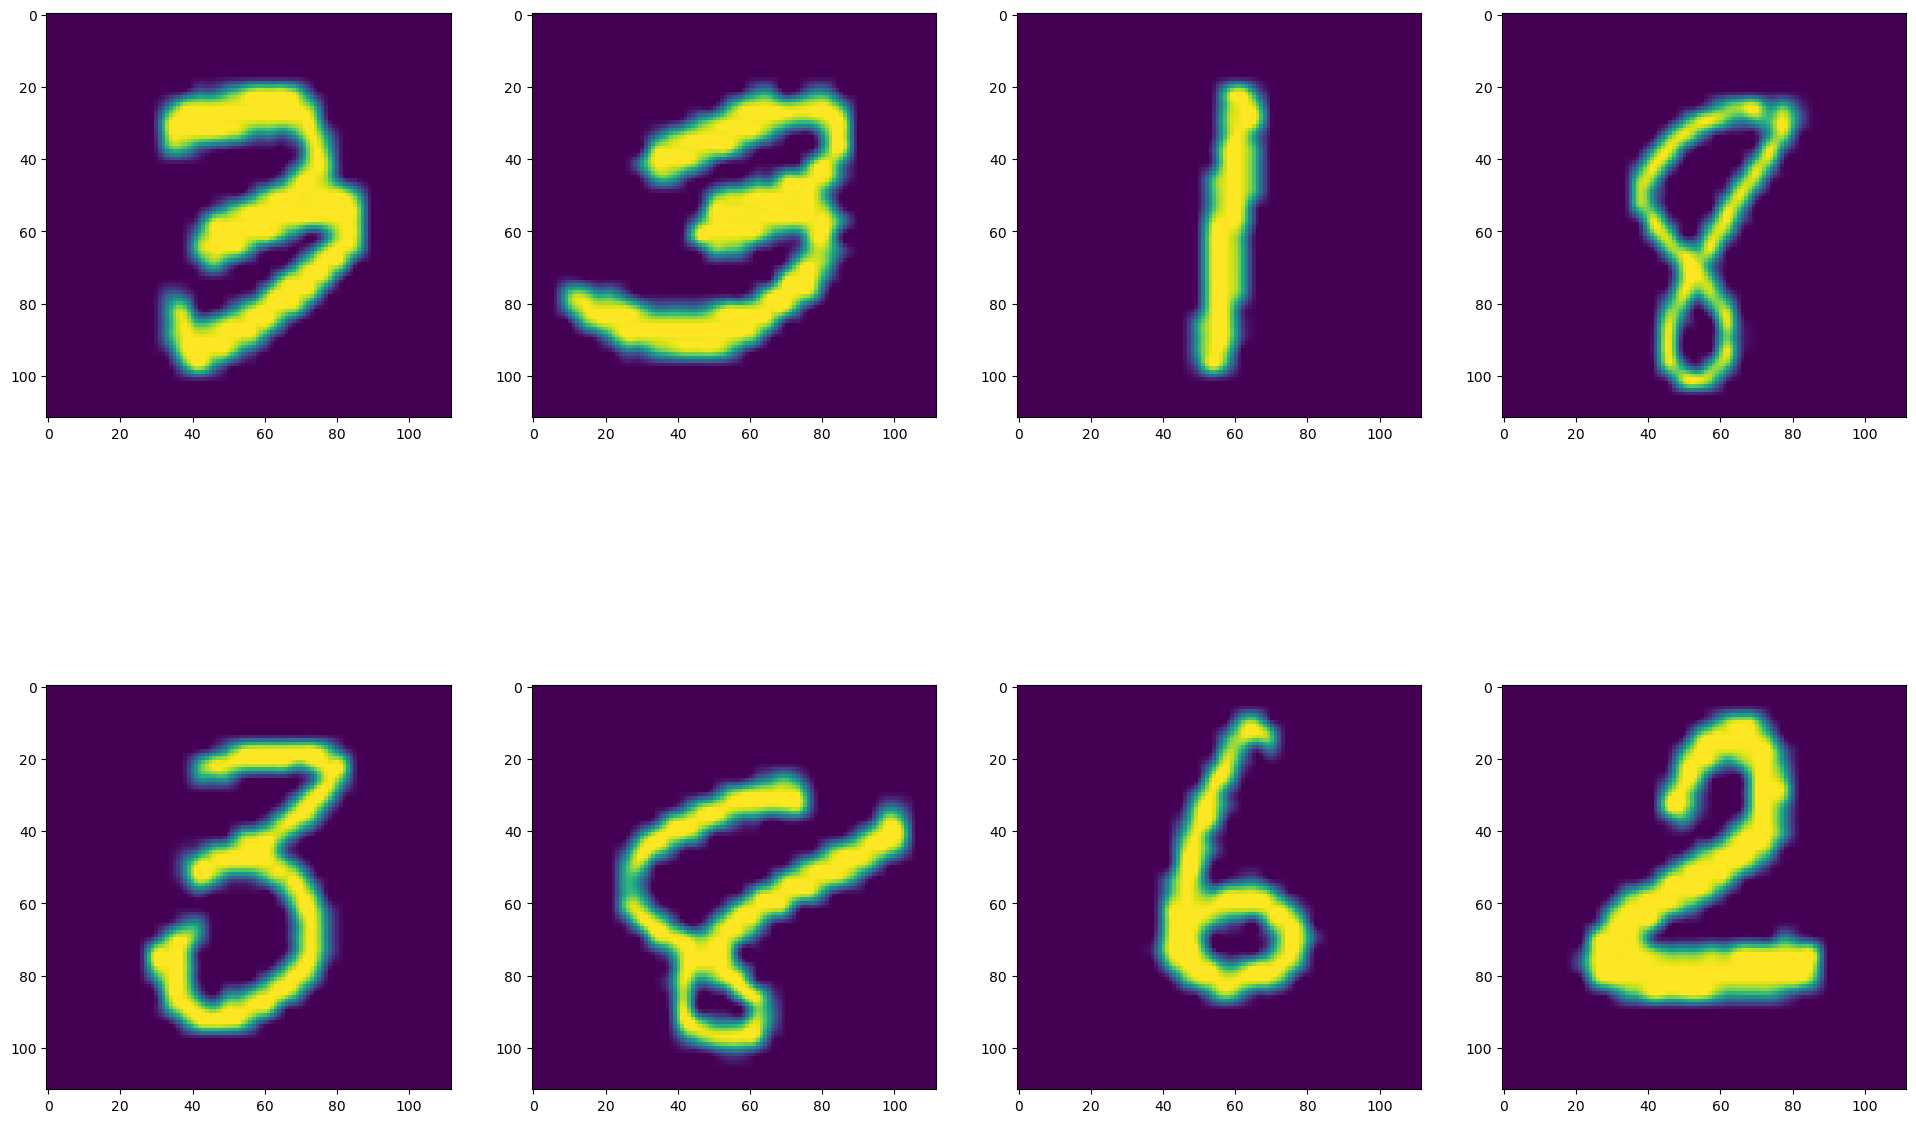

In [26]:
fig,axs = plt.subplots(2,4,figsize=(24,16))
for i in range(0,4):
    axs[0,i].imshow(p[0][i,:,:,0])
    axs[1,i].imshow(p[1][i,:,:,0])
    
print(t[0:4])

[0. 0. 0. 0.]


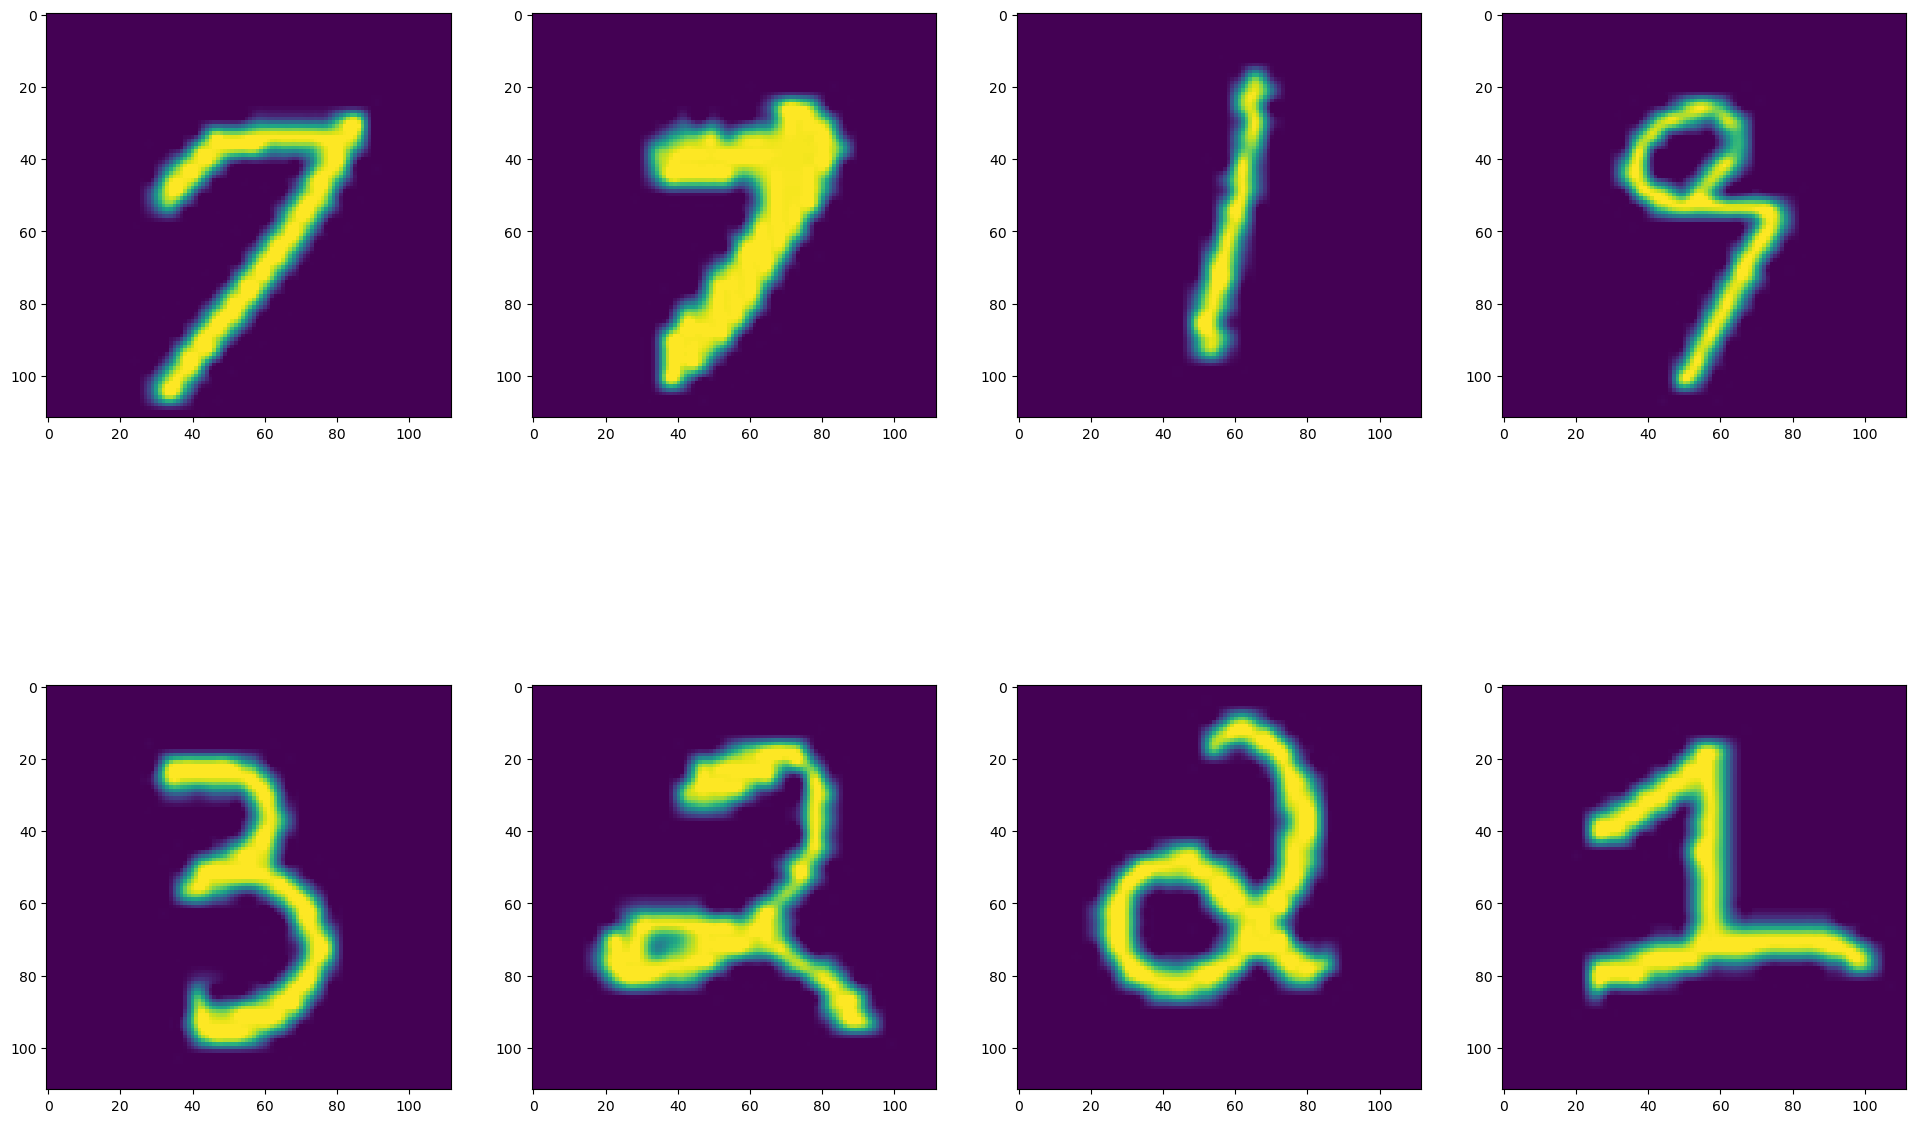

In [27]:
fig,axs = plt.subplots(2,4,figsize=(24,16))
for i in range(5,9):
    axs[0,i-5].imshow(p[0][i-1,:,:,0])
    axs[1,i-5].imshow(p[1][i-1,:,:,0])
print(t[4:])

In [28]:
def generate(batch_size):
        """a generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = get_batch(batch_size)
            yield (pairs, targets)

In [29]:
def test_oneshot(model,N,k,verbose=0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        pass

In [31]:
evaluate_every = 10 # interval for evaluating on one-shot tasks
loss_every = 200 # interval for printing loss (iterations)
batch_size = 32
n_iter = 20000
N_way = 20 # how many classes for testing one-shot tasks>
n_val = 250 # how many one-shot tasks to validate on?
best = -1
training_loss = []
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter):
    (inputs,targets) = make_batch(batch_size)
    loss=model.train_on_batch(inputs,targets)
    training_loss.append(loss)
    if i%100==0:
        print(f"Iteration {i} Loss: {loss}\n-------------") 
#     if i % evaluate_every == 0:
#         print("Time for {0} iterations: {1}".format(i, time.time()-t_start))
#         val_acc = loader.test_oneshot(model,N_way,n_val,verbose=True)
#         if val_acc >= best:
#             print("Current best: {0}, previous best: {1}".format(val_acc, best))
#             print("Saving weights to: {0} \n".format(weights_path))
#             model.save_weights(weights_path_2)
#             best=val_acc
    
    if i % loss_every == 0:
        print("iteration {}, training loss: {:.2f},".format(i,loss))

        
weights_path_2 = os.path.join(data_path, "model_weights.h5")
model.load_weights(weights_path_2)

Starting training process!
-------------------------------------
Iteration 100 Loss: 0.7868545055389404
-------------
Iteration 200 Loss: 0.7096359729766846
-------------
iteration 200, training loss: 0.71,
Iteration 300 Loss: 0.6256008744239807
-------------
Iteration 400 Loss: 0.5375370383262634
-------------
iteration 400, training loss: 0.54,
Iteration 500 Loss: 0.5189065337181091
-------------
Iteration 600 Loss: 0.43520477414131165
-------------
iteration 600, training loss: 0.44,


KeyboardInterrupt: 

NameError: name 'training_loss' is not defined

In [33]:
def make_test_batch(batch_size):
    scale_factor=4
    # Upscale using cv2.resize
    upscaled_xtest = np.empty((10000,112,112))

    for i, image in enumerate(xtest):
        upscaled_xtest[i] = cv2.resize(image, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)
    X = upscaled_xtest
    Y = ytest
    n_examples,w,h = X.shape
    n_classes = np.unique(ytest)
    categories = rng.choice(n_classes,size=(batch_size,),replace=True)
    pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
    targets=np.zeros((batch_size,))
    targets[batch_size//2:] = 1
    for i in range(batch_size):
            category = categories[i]
            idx_1 = rng.randint(0, n_examples)
            pairs[0][i,:,:,:] = X[idx_1].reshape(w, h, 1)
            idx_2 = rng.randint(0, n_examples)
            #pick images of same class for 1st half, different for 2nd
            if ytest[idx_1] == ytest[idx_2]:
                targets[i] = 1  
            else: 
                #add a random number to the category modulo n classes to ensure 2nd image has
                # ..different category
                #category_2 = (category + rng.randint(0,9)) % n_classes
                targets[i] = 0
            pairs[1][i,:,:,:] = X[idx_2].reshape(w, h,1)
    return pairs, targets
    
ptest,ttest = make_test_batch(8)

In [ ]:
plt.plot(range(0,len(training_loss)),training_loss,'b')
plt.plot(range(0,len(test_loss)),testing_loss,'r')